[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb)

In [9]:
%pip install -qU langgraph langchain langchain-ollama pip typing-extensions duckduckgo-search langchain_community python-dotenv langchain-openai

Note: you may need to restart the kernel to use updated packages.


In [10]:
from dotenv import load_dotenv

load_dotenv()

True

In [11]:
from langchain_openai import ChatOpenAI
from langchain_community.tools import DuckDuckGoSearchResults
from langchain_ollama import ChatOllama

web_search_tool = DuckDuckGoSearchResults()
tools = [web_search_tool]
llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0.1)

In [12]:
from typing_extensions import TypedDict
from typing import Literal, Annotated
from langchain_ollama import ChatOllama
from langgraph.graph import MessagesState
from langgraph.types import Command
from langgraph.constants import END
from langgraph.prebuilt import create_react_agent
from langchain_core.messages import HumanMessage, AIMessage

members_with_desc = {
    "researcher": "This worker researches the internet for you and then answers.",
    "recommender": "This worker recommends product suitable to handle problems with our products further."
}

members = list(members_with_desc.keys())

options = members + ["FINISHED"]

supervisor_system_prompt = (f"""You must not answer but only assign the worker to be next called.
You must understand the intention of the user in order to call the workers and also use the previous messages as references.
You have access to only these workers, {members} with what they do:
{members_with_desc}
One worker must be called only one time
If the all the workers have been called once or there is nothing to generate, then only set next to "FINISHED".
Don't change the name of the workers listed.
next field must be only worker's name only or "FINISHED" if none.
Given the following user request,
respond with the worker's name to act next.
""")


class Router(TypedDict):
    next: Literal[*options]

test = llm.invoke("Hi!")
#print(test)
def supervisor_node(state: MessagesState) -> Command[Literal[*members, "__end__"]]:
    message = [
        {"role": "system", "content": supervisor_system_prompt}
    ] + state["messages"]
    #print(message)
    #print(llm.invoke(message))
    response = llm.with_structured_output(Router).invoke(message)
    #print(response)
    goto = response["next"]
    if goto == "FINISHED":
        goto = END
    return Command(goto=goto)

research_agent = create_react_agent(llm, tools=[web_search_tool], state_modifier="You are a researcher. If you are unsure, do not apply your previous knowledge.")

def research_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    result = research_agent.invoke(state)

    return Command(
        update={
            "messages": [
                AIMessage(content=result["messages"][-1].content, name="researcher")
            ]
        }, goto="supervisor"
    )

products = {
    "Voice Grid (https://voicegrid.pannalabs.ai/)": "It is a product that converts Voice Input to a Structured Journal, Can be used in therapy, roaster creation, excel sheet generation. Its very fast because you don't need to type at all.",
    "Web 2 Bot (https://www.webtobot.com/)": "It scraps the website and answers for that data only. Recommend it only to business or large organizations holding an website."
}

product_options = list(products.keys()) + ["NONE"]

recommender_system_message = (f"""You are a product recommender.
Read the message and try to guess if any on of the given products could be recommended.
If there is nothing to that can be recommend do not recommend and set product to "NONE".
Here are the products with their description/use cases:
{products}
""")

class Recommendation(TypedDict):
    product: Literal[*product_options, None]

def recommender_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    message = [
        {"role": "system", "content": recommender_system_message}
    ] + state["messages"]
    response = llm.with_structured_output(Recommendation).invoke(message)
    #print(response)
    recommended_product = response["product"]
    if not recommended_product == "NONE":
        return Command(
            update={
                "messages": [
                    AIMessage(content=f"I recommend you to use {recommended_product}", name="recommender")
                ]
            },
            goto="supervisor"
        )
    return Command(
        update={
            "messages":[
                AIMessage(content="NONE", name="recommender")
            ]
        },
        goto="supervisor"
    )

In [13]:
from langgraph.constants import START
from langgraph.graph import StateGraph

# building a graph
builder = StateGraph(MessagesState)
builder.add_edge(START, "supervisor")
builder.add_node("supervisor", supervisor_node)
builder.add_node("researcher", research_node)
builder.add_node("recommender", recommender_node)
graph = builder.compile()

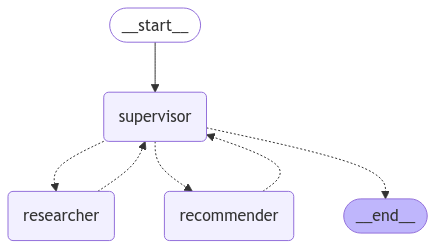

In [14]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:
for s in graph.stream(
    {"messages": [("user", "Who is current world chess champion?")]}, subgraphs=True
):
    print(s)
    print("----")

((), {'supervisor': None})
----
(('researcher:61b0082e-afe7-11f9-2215-b6bc37f28a00',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_onTkzAes4LUyy09eKSUva2cd', 'function': {'arguments': '{"query":"current world chess champion 2023"}', 'name': 'duckduckgo_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 98, 'total_tokens': 123, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_d02d531b47', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-9d9dc93d-120b-4128-a1c5-f1cf3698ca03-0', tool_calls=[{'name': 'duckduckgo_results_json', 'args': {'query': 'current world chess champion 2023'}, 'id': 'call_onTkzAes4LUyy09eKSUva2cd', 'type': 'tool

In [7]:
def execute(msg):
    response =  graph.invoke(
        {"messages": [("user", msg)]}, subgraphs=True
    )
    [r.pretty_print() for r in response[1]["messages"]]

message = ""
while not message == "exit":
    message = input("> ")
    if message.lower() in ["quit", "q", "exit"]:
        break
    execute(message)

>  I am website owner. How can I increase the UX of my website?


================================ Human Message =================================

I am website owner. How can I increase the UX of my website?
================================== Ai Message ==================================
Name: researcher

Improving the user experience (UX) of your website involves several strategies and best practices. Here are some effective ways to enhance UX:

1. **Responsive Design**: Ensure your website is mobile-friendly and looks good on all devices. Use responsive design techniques to adapt layouts to different screen sizes.

2. **Fast Loading Times**: Optimize your website's speed by compressing images, minimizing code, and using efficient hosting. Tools like Google PageSpeed Insights can help identify areas for improvement.

3. **Intuitive Navigation**: Create a clear and logical navigation structure. Use descriptive labels for menu items and ensure users can easily find what they are looking for.

4. **Consistent Layout**: Maintain a consistent layout and

>  I need a tool to quickly create notes.


================================ Human Message =================================

I need a tool to quickly create notes.
================================== Ai Message ==================================
Name: recommender

I recommend you to use Voice Grid (https://voicegrid.pannalabs.ai/)


>  quit
